In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import sklearn.metrics as metrics
import statsmodels.api as sm

In [2]:
df = pd.read_csv('./kaggle_data/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# These are the manually picked columns that are all categorical
total_categorical_cols = ['MSZoning', 'Street', 'Alley', 'LandContour', 
                    'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
                    'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
                    'ExterCond', 'Foundation', 'Heating', 'CentralAir', 'PavedDrive',
                    'MiscFeature', 'SaleType', 'SaleCondition']

# These columns will have to be manually processed
total_rating_cols = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 
                   'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                  'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
                    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']

#########
# Below will be the columns actually used in the model
#########

category_cols = ['Neighborhood', 'SaleType']
rating_cols = ['ExterQual', 'ExterCond']
continuous_cols = ['OverallQual', 'GrLivArea', 'YearBuilt']

In [4]:
# Creating the rating columns (example of how to convert to a rating scale)
rating_df = df[rating_cols].copy()
rating_df.replace('Ex', 5, inplace=True)
rating_df.replace('Gd', 4, inplace=True)
rating_df.replace('TA', 3, inplace=True)
rating_df.replace('Fa', 2, inplace=True)
rating_df.replace('Po', 1, inplace=True)

# rating_df['Col'].replace('Hot', 4, inplace=True)

rating_df

,ExterQual,ExterCond
0,4,3
1,3,3
2,4,3
3,3,3
4,4,3
...,...,...
1455,3,3
1456,3,3
1457,5,4
1458,3,3


In [5]:
# Select categorical columns and get dummy column values (different approach from what we did before with category type)
# Preferably pick columns that are not like rating columns (Bad, Okay, Great). We should handle those separately
dummy_df = pd.get_dummies(df[category_cols])
dummy_df.head()

,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,...,Neighborhood_Veenker,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
YVar = df[['SalePrice']]
XVar = pd.concat([df[continuous_cols], dummy_df, rating_df], axis=1)
XVar.head()

,OverallQual,GrLivArea,YearBuilt,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,...,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,ExterQual,ExterCond
0,7,1710,2003,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,4,3
1,6,1262,1976,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3,3
2,7,1786,2001,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,4,3
3,7,1717,1915,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,3,3
4,8,2198,2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,4,3


In [7]:
# Split data 80-20 so we can test how well the model works
msk = np.random.rand(len(df)) < 0.8

train_x = XVar[msk]
train_y = YVar[msk]

test_x = XVar[~msk]
test_y = YVar[~msk]

In [8]:
# Run linear regression with statsmodels to get statistics
sm_linear_model = sm.OLS(train_y, train_x).fit()
print(sm_linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     122.0
Date:                Sun, 12 Apr 2020   Prob (F-statistic):               0.00
Time:                        15:25:52   Log-Likelihood:                -14079.
No. Observations:                1181   AIC:                         2.823e+04
Df Residuals:                    1143   BIC:                         2.843e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
OverallQual           1.705e+04 

In [9]:
# Run linear regression with sklearn
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)

# Make predictions using the testing set, then convert to pandas series
saleprice_preds = regr.predict(test_x)
saleprice_preds = pd.Series([x for lst in saleprice_preds for x in lst])

# Print out coefficient information (coefficient of determination is perfect if it is 1)
#print('Coefficients: \n', regr.coef_)
explained_variance = metrics.explained_variance_score(test_y, saleprice_preds)
mean_absolute_error = metrics.mean_absolute_error(test_y, saleprice_preds) 
mse = metrics.mean_squared_error(test_y, saleprice_preds) 
mean_squared_log_error = metrics.mean_squared_log_error(test_y, saleprice_preds)
median_absolute_error = metrics.median_absolute_error(test_y, saleprice_preds)
r2 = metrics.r2_score(test_y, saleprice_preds)

print('explained_variance: ', round(explained_variance,4))    
print('mean_squared_log_error: ', round(mean_squared_log_error,4))
print('r2: ', round(r2,4))
print('MAE: ', round(mean_absolute_error,4))
print('MSE: ', round(mse,4))
print('RMSE: ', round(np.sqrt(mse),4))

explained_variance:  0.8171
mean_squared_log_error:  0.0807
r2:  0.8168
MAE:  21618.6803
MSE:  930450689.7898
RMSE:  30503.2898


In [10]:
# Construct the results dataframe
actual_price = test_y.reset_index()['SalePrice']
pred_price = saleprice_preds.round()

res = pd.DataFrame({'actual_price': actual_price, 'predicted_price': pred_price})
res

,actual_price,predicted_price
0,250000,320551.0
1,157000,152403.0
2,90000,123995.0
3,230000,241772.0
4,129900,103433.0
...,...,...
274,64500,77933.0
275,120500,100421.0
276,121000,121330.0
277,179600,205024.0


In [11]:
res['diff'] = res.actual_price - res.predicted_price
res['percent_diff'] = (res['diff'] / res.actual_price * 100).round(decimals=2)
res

,actual_price,predicted_price,diff,percent_diff
0,250000,320551.0,-70551.0,-28.22
1,157000,152403.0,4597.0,2.93
2,90000,123995.0,-33995.0,-37.77
3,230000,241772.0,-11772.0,-5.12
4,129900,103433.0,26467.0,20.37
...,...,...,...,...
274,64500,77933.0,-13433.0,-20.83
275,120500,100421.0,20079.0,16.66
276,121000,121330.0,-330.0,-0.27
277,179600,205024.0,-25424.0,-14.16


In [12]:
print('Average percent_difference: %.2f' % (res.percent_diff.abs().mean()))

Average percent_difference: 14.40


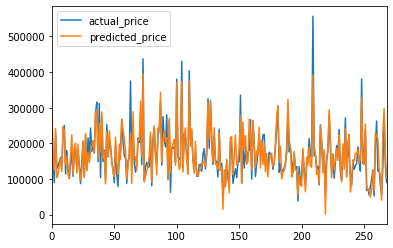

In [14]:
# Predicted price is actually really close to actual, but not when actual price is very very high
res.head(-10).plot(kind='line', y=['actual_price', 'predicted_price'])